# Week 2: Fast pipelines, profiling
While implementing a deep learning pipeline, you might encounter bottlenecks in different parts of your solution: from loading data to model execution. In this seminar, we will try to highlight the key points in DL pipelines to pay attention to.

### Seminar outline
1. Faster training
    - Automatic mixed precision (AMP)
    - FP8 training
    - Tensor cores on GPU
2. Profiling
    - General purpose Python profiling with `py-spy`
    - PyTorch profiler
    - Memory profiling
    - Profiling with Nsight Systems
3. Efficient batching for LM
    - Extra: streaming data using Hugging Face Datasets
4. Data loading from disk: image decoder benchmarks
5. Data augmentations on GPU: Nvidia DALI

## 0. Before we start

In [ ]:
# !pip install -r requirements.txt
# !nvidia-smi

## 1. Faster training
### Automatic mixed precision (AMP)
Let's use a simple MNIST training example to see the difference between full precision training, half precision training and mixed precision training.

In [4]:
import torch
import torch.nn as nn
import torchvision

device = torch.device("cuda:0")

In [5]:
# very standard data things
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=1024, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=1024, shuffle=False
)

In [27]:
from train import create_model, train, train_amp

Firstly, let's check that full precision training converges to a reasonable accuracy score.

In [8]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, n_epochs=1)

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 16.65it/s]


Starting validation...
Epoch: 0, loss: 0.1278335601091385, accuracy: 0.9596061706542969


Now, let's try to cast both the model and the data to half precision. The training process diverges because of the division by overflowing values in Adam.

In [9]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=1)

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 15.32it/s]


Starting validation...
Epoch: 0, loss: nan, accuracy: 0.09818439185619354


In [10]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float16
Optimizer first moment dtype: torch.float16
Optimizer second moment dtype: torch.float16


Let's try to use another optimizer that avoids divisions.

In [11]:
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=3)

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 15.95it/s]


Starting validation...
Epoch: 0, loss: 1.0599762201309204, accuracy: 0.6599230766296387


Epoch 2: 100%|██████████| 59/59 [00:03<00:00, 15.91it/s]


Starting validation...
Epoch: 2, loss: 0.1744827926158905, accuracy: 0.9484135508537292


In [12]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-4)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=1)

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 15.62it/s]


Starting validation...
Epoch: 0, loss: 1.321211338043213, accuracy: 0.5289441347122192


Now, let's go to AMP.

We can check the list of [CUDA Ops that can autocast to float16]((https://pytorch.org/docs/stable/amp.html#cuda-ops-that-can-autocast-to-float16)).

`\_\_matmul\_\_, addbmm, addmm, addmv, addr, baddbmm, bmm, chain_matmul, multi_dot, conv1d, conv2d, conv3d, conv_transpose1d, conv_transpose2d, conv_transpose3d, GRUCell, linear, LSTMCell, matmul, mm, mv, prelu, RNNCell`

Below, you can see a visualization of mixed precision training with loss scaling applied:

![Mixed precision](./images/mixed_precision.jpeg)

Loss (de)scaling has the following effect on the range of the gradients:

![Mixed precision range](./images/loss_scaling.png)

In [14]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="fp16")

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 17.46it/s]


Starting validation...
Epoch: 0, loss: 0.11965407431125641, accuracy: 0.9623087048530579


Epoch 2: 100%|██████████| 59/59 [00:03<00:00, 17.60it/s]


Starting validation...
Epoch: 2, loss: 0.07164657860994339, accuracy: 0.9768494367599487


In [15]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float32
Optimizer first moment dtype: torch.float32
Optimizer second moment dtype: torch.float32


In [16]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=True, precision="fp16")

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 17.65it/s]


Starting validation...
Epoch: 0, loss: 0.13270071148872375, accuracy: 0.9589964151382446


Epoch 2: 100%|██████████| 59/59 [00:03<00:00, 17.46it/s]


Starting validation...
Epoch: 2, loss: 0.0826612040400505, accuracy: 0.9736726880073547


In [17]:
model = create_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="bf16")

Epoch 0: 100%|██████████| 59/59 [00:03<00:00, 17.26it/s]


Starting validation...
Epoch: 0, loss: 0.12389050424098969, accuracy: 0.9606126546859741


Epoch 2: 100%|██████████| 59/59 [00:03<00:00, 16.85it/s]


Starting validation...
Epoch: 2, loss: 0.08508770167827606, accuracy: 0.9726223945617676


As you can see, the computation time does not differ between all these versions. Why is that the case?

Note: the original model weights are always in full precision. However, under the hood, there is also an FP16 copy of the model, thus the gradients can be computed quickly. But when do we create this copy? We will check it later

In this section, we will briefly examine the time and memory consumption of full, half and mixed precision modes. Actually, the results are pretty much as you expect.

In [18]:
import gc
from time import time

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange

device = torch.device("cuda:0")

# Timing utilities
start_time = None

batch_size = 512  # Try, for example, 128, 256, 513
in_size = 4096 + 2048
out_size = 4096 + 2048
num_layers = 3
num_batches = 50
epochs = 3


def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    start_time = time()


def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time()
    print("\n" + local_msg)
    print(f"Total execution time = {end_time - start_time:.3f} sec")
    print(
        f"Max memory used by tensors = {torch.cuda.max_memory_allocated() // 1_000_000} megabytes"
    )

def create_model(in_size: int, out_size: int, num_layers: int) -> torch.nn.Module:
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers))

In [19]:
# Creates data in default precision.
# The same data is used for both default and mixed precision trials below.
# You don't need to manually change inputs' dtype when enabling mixed precision.
data = [torch.randn(batch_size, in_size, device=device) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size, device=device) for _ in range(num_batches)]
loss_fn = torch.nn.MSELoss().to(device)

In [20]:
net = create_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad()  # set_to_none=True here can modestly improve performance
end_timer_and_print("Full precision:")

100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


Full precision:
Total execution time = 0.302 sec
Max memory used by tensors = 2271 megabytes


In [21]:
net = create_model(in_size, out_size, num_layers)
net.half().to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input.half())
        loss = loss_fn(output, target.half())
        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Half precision:")

100%|██████████| 3/3 [00:00<00:00, 11.44it/s]


Half precision:
Total execution time = 0.293 sec
Max memory used by tensors = 2063 megabytes


In [22]:
net = create_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Mixed precision without scaling:")

100%|██████████| 3/3 [00:00<00:00, 12.31it/s]


Mixed precision without scaling:
Total execution time = 0.288 sec
Max memory used by tensors = 2327 megabytes


In [23]:
net = create_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision with scaling:")

100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


Mixed precision with scaling:
Total execution time = 0.356 sec
Max memory used by tensors = 2535 megabytes


### FP8 training

Scaling is a bit harder here. FP8's dynamic range can handle individual activations or gradients, but not all of them together. Unlike FP16, which uses one global loss scaling factor, FP8 requires a separate scaling factor per every tensor.

There are two FP8 formats commonly used: E4M3 (4 exponent, 3 mantissa bits) for weights, activations, and gradients with respect to activations, and E5M2 (5 exponent, 2 mantissa bits) for gradients with respect to weights. Gradients use E5M2 because they exhibit higher variance within each tensor, requiring the extra exponent bit for range over precision.

![FP8 Scaling](./images/FP8.png)

A generalization of this approach (used by DeepSeek) is blockwise scaling: choosing a scaling factor per each tensor block rather than per tensor. The scale is computed using amax (absolute maximum):

$$\text{scale} = \frac{\max(|block|)}{\max_{fp8}}$$

This provides finer granularity, but comes with a trade-off: smaller blocks mean more scaling factors to store and compute. In the extreme case of one scale per element, you'd have as much overhead as just using FP32.

A hardware-accelerated format called **MXFP8** addresses this by using blocks of 32 consecutive values, each with its own scaling factor. This finer granularity allows all values (including gradients) to use E4M3. Additionally, MXFP8 stores scaling factors as E8M0 (8-bit power of 2) instead of FP32 (E8M23), reducing the overhead of having more scales.

![MXFP8 Scaling](./images/MXFP8.png)

For those interested in a deeper understanding of FP8 training:

1) [Using FP8 with Transformer Engine](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/examples/fp8_primer.html)
2) [FP8 Formats For Deep Learning](https://arxiv.org/pdf/2209.05433)

### Tensor cores
One of the important constraints for tensor cores to be activated is that dimensions sizes must be divisible by 8 (for Nvidia V100 GPU). Let's check this fact. We'll run two models: one is slightly bigger but satisfies constraints for tensor core activation, the other one is smaller and does not satisfy such constraints.

In [24]:
data_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]
targets_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]

data_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]
targets_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]

net_8192 = create_model(8192, 8192, num_layers).to(device)
opt_8192 = torch.optim.SGD(net_8192.parameters(), lr=0.001)
scaler_8192 = torch.cuda.amp.GradScaler(enabled=True)

net_8191 = create_model(8191, 8191, num_layers).to(device)
opt_8191 = torch.optim.SGD(net_8191.parameters(), lr=0.001)
scaler_8191 = torch.cuda.amp.GradScaler(enabled=True)

loss_fn = torch.nn.MSELoss().to(device)

# warmup
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)

# with tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)
            loss = loss_fn(output, target)

        scaler_8192.scale(loss).backward()
        scaler_8192.step(opt_8192)
        scaler_8192.update()
        opt_8192.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8192:")

# without tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8191, targets_8191):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8191(input)
            loss = loss_fn(output, target)
        scaler_8191.scale(loss).backward()
        scaler_8191.step(opt_8191)
        scaler_8191.update()
        opt_8191.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8191:")

100%|██████████| 3/3 [00:00<00:00,  5.11it/s]



Mixed precision, in/out dim 8192:
Total execution time = 0.589 sec
Max memory used by tensors = 7711 megabytes


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Mixed precision, in/out dim 8191:
Total execution time = 1.137 sec
Max memory used by tensors = 7711 megabytes


## 2. Profiling

In this section, we will profile the MNIST training code from the examples above.

Profiling has two main goals:
- Avoid computational devices idling while waiting each other to finish their jobs (e.g.,  CPU bottlenecks for deep learning pipelines)
- Reveal the most computationally heavy parts of your code, so you can analyse and optimise them algorithmically or architecturally

### General-purpose Python profiling with `py-spy`

For general-purpose Python profiling, we can use `py-spy` or [`scalene`](https://github.com/plasma-umass/scalene).
The main advantage of such tools is that no interaction with source code is needed.
You can even attach a profiler to a running process.

First, let's examing `mnist_training.py`.
Then, we will run it: `python mnist_training.py`

Run:
```
sudo py-spy record -o profile.svg --pid <get_pid>
sudo py-spy top --pid <get_pid>
```

For `scalene`, run:
```
scalene run mnist_training.py
scalene view --cli
```

Try different levels of transforms.

In [ ]:
!python3 mnist_training.py

### Deep learning profiling: PyTorch Profiler

While py-spy gives a general view of Python execution, it gives you poor understanding of what's happening with GPU operations.
PyTorch's built-in profiler is designed specifically for deep learning workloads, tracking the execution of CUDA kernels and memory allocations.

More information about the PyTorch Profiler can be found [here](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

In [ ]:
import torch
import torchvision.models as models
from torch.profiler import ProfilerActivity, profile, record_function

from train import create_model

Let's profile everything: CPU, CUDA activities, and also add python call stack. We can then render the results using the [Perfetto UI](https://ui.perfetto.dev/).

In [28]:
model = create_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

with profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
) as prof:
    epoch = 0
    model.train()
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        prof.step()

prof.export_chrome_trace("trace.json")

Epoch 0:   7%|▋         | 4/59 [00:00<00:06,  8.53it/s]STAGE:2026-01-21 17:53:06 206018:206018 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2026-01-21 17:53:06 206018:206018 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
Epoch 0: 100%|██████████| 59/59 [00:11<00:00,  5.14it/s]


#### CPU Activities

In [29]:
model = models.resnet18().to(device)
inputs = torch.randn(5, 3, 224, 224).to(device)

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

STAGE:2026-01-21 18:03:23 206018:206018 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/root/efficient-dl-hw3/week03_fast_pipelines/seminar/seminar/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
STAGE:2026-01-21 18:03:23 206018:206018 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2026-01-21 18:03:23 206018:206018 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [30]:
print(
    prof.key_averages().table(
        sort_by="cpu_time_total", row_limit=10
    )
)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         3.21%       1.822ms       100.00%      56.714ms      56.714ms             1  
                                           aten::conv2d         0.27%     154.000us        72.97%      41.385ms       2.069ms            20  
                                      aten::convolution         0.29%     167.000us        72.87%      41.325ms       2.066ms            20  
                                     aten::_convolution         0.20%     115.000us        72.57%      41.158ms       2.058ms            20  
      

In [31]:
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=10
    )
)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                        model_inference         3.21%       1.822ms       100.00%      56.714ms      56.714ms             1                                                                                []  
                                   cudaFuncSetAttribute        29.74%      16.869ms        29.74%      1

#### CPU + CUDA Activities

In [32]:
with profile(
    activities=[ProfilerActivity.CUDA, ProfilerActivity.CPU], record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us       2.903ms        80.95%       2.903ms       2.903ms             1  
                                        model_inference        13.98%     731.000us        98.05%       5.128ms       5.128ms       0.000us         0.00%     683.000us     683.000us             1  
         

STAGE:2026-01-21 18:05:24 206018:206018 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2026-01-21 18:05:24 206018:206018 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2026-01-21 18:05:24 206018:206018 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### Memory profiling

Understanding memory usage is critical for training large models.
The most common questions are:
- Why am I running out of memory?
- Which layer allocates the most memory?
- Where are the memory spikes?

PyTorch provides two tools for it:
- Profiler with `profile_memory=True` – shows memory per operation in a table
- Memory snapshots – capture the full state of GPU memory during training

In [33]:
with profile(
    activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True
) as prof:
    model(inputs)

print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cuda_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                            aten::empty         6.47%     262.000us         6.47%     262.000us       2.620us           0 b           0 b      

STAGE:2026-01-21 18:08:21 206018:206018 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2026-01-21 18:08:21 206018:206018 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2026-01-21 18:08:21 206018:206018 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Let's try to record a memory snapshot now. Here is the PyTorch documentation on that: [Understanding CUDA Memory Usage](https://pytorch.org/docs/stable/torch_cuda_memory.html). The resulting artifact is a Pickle file that can be drag-and-dropped into https://pytorch.org/memory_viz for interactive visualization.

Here's an example of what the memory snapshot visualization looks like:

![Memory Snapshot](./images/mem_snapshot.jpeg)

We will now compare memory snapshots of training with AMP and without it.

In [ ]:
!python3 memory_snapshot.py

In [ ]:
!python3 memory_snapshot.py --amp

Further reading:
- [Understanding GPU Memory 1: Visualizing All Allocations over Time](https://pytorch.org/blog/understanding-gpu-memory-1/)
- [Understanding GPU Memory 2: Finding and Removing Reference Cycles](https://pytorch.org/blog/understanding-gpu-memory-2/)
- [Article by Hugging Face](https://huggingface.co/blog/train_memory)

### Profiling with Nsight systems

For the most detailed GPU code execution analysis, Nvidia provides a system-wide performance analysis tool called [Nsight Systems](https://developer.nvidia.com/nsight-systems/get-started).

Run `nsys profile python3 mnist_training.py`.

It will generate a `.nsys-rep` file that can be opened in the Nsight Systems GUI for interactive visualization.

In [ ]:
!nsys profile python3 mnist_training_nsys.py

In [ ]:
!nsys profile --stats=true -o profile_report --gpu-metrics-device=all -t cuda,nvtx,osrt,cudnn,cublas python3 mnist_training_nsys.py

## 3. Efficient batching for language models

Let's recall that working with data in Pytorch is usually divided into two different entities: `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`.
In the class inherited from `torch.utils.data.Dataset`, you must implement three methods: `__init__` and `__getitem__` (obligatory) and `__len__` (preferable but not obligatory).
In turn, `torch.utils.data.Dataloader` spawns different CPU workers which call the dataset's `__getitem__` method and combine batches for training iterations.

The standard batching approach (default `collate_fn`) is just to stack tensors acquired with `__getitem__`. However, sometimes it is not enough, because we might need additional operations to be made with each element of the batch. The examples of such scenarios are:

- Sequences of variable length
- Different label vector/matrix sizes per sample
- Other batch-level preprocessing steps

In [35]:
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

Now, let's compare different techniques for batching text samples:

**BRAIN**: pad everything to a fixed `max_length`.

**BIG BRAIN (THIS SECTION)**: pad only in the `collate_fn`.

**ULTRA BIG BRAIN (HOMEWORK)**: presort data to sample sequences smartly, preserving the similarity of example length in the batch.

**ULTRA DUPER BIG BRAIN (HOMEWORK)**: pack all sequences into one long sequence and generate the metadata that indicates where each original sequence starts and ends. This minimizes padding and improves the computational efficiency by maximizing the use of available space.

In [36]:
lines = [
    "One thing I don't know why",
    "It doesn't even matter how hard you try",
    "Keep that in mind, I designed this rhyme",
    "To explain in due time",
    "All I know",
    "Time is a valuable thing",
    "Watch it fly by as the pendulum swings",
    "Watch it count down to the end of the day",
    "The clock ticks life away",
    "It's so unreal",
    "Didn't look out below",
    "Watch the time go right out the window",
    "Tryin' to hold on, did-didn't even know",
    "I wasted it all just to watch you go",
    "I kept everything inside and even though I tried",
    "It all fell apart",
    "What it meant to me will eventually",
    "Be a memory of a time when I tried so hard",
    "I tried so hard and got so far",
    "But in the end it doesn't even matter",
    "I had to fall to lose it all",
    "But in the end it doesn't even matter",
]
labels = torch.randint(2, (len(lines),))
dataset = list(zip(lines, labels))
tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(iter(dataset)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))


def collate_batch(
    batch: list[tuple[str, torch.Tensor]]
) -> tuple[torch.Tensor, torch.Tensor]:
    text_list, label_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.int64)

    return text_list, label_list


dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_batch, shuffle=True)

for x, _ in dataloader:
    print(f"Current batch:\n{x}\n")

Current batch:
tensor([[22,  9,  4, 15,  1, 14,  3,  6,  7, 18],
        [ 2, 19, 10, 16, 21, 50, 10, 47,  0,  0]])

Current batch:
tensor([[ 5, 45,  9, 42, 11,  0,  0,  0,  0,  0,  0],
        [31, 13, 64, 24, 13, 11, 83,  2, 19, 10, 16]])

Current batch:
tensor([[57, 73,  9, 65, 20,  2, 37, 74, 69],
        [ 1,  3, 71, 10, 79,  0,  0,  0,  0]])

Current batch:
tensor([[ 1,  8, 48, 28,  0,  0,  0,  0,  0,  0],
        [ 1, 14,  3,  6,  7, 18, 53, 16, 27, 77]])

Current batch:
tensor([[ 2, 51,  5, 46,  5, 61,  1,  8,  0,  0],
        [12,  1, 35, 41,  5,  4, 15, 24,  4, 36]])

Current batch:
tensor([[12,  4, 11, 23, 70, 25,  4, 86],
        [ 8,  2, 17,  0,  0,  0,  0,  0]])

Current batch:
tensor([[82,  1, 63,  5, 62, 85, 43,  0],
        [12,  1, 49, 33, 29,  4, 68, 72]])

Current batch:
tensor([[ 2, 58, 44, 54, 21,  7, 75,  2, 19,  0,  0],
        [78,  3,  5, 52, 66, 20, 38,  3,  6,  7, 17]])

Current batch:
tensor([[ 4, 34, 76, 59, 30],
        [11, 55, 13, 80, 26]])

Current bat

Also, check out the [docs](https://huggingface.co/docs/transformers/main_classes/data_collator) for `transformers.DataCollatorWithPadding`.

#### Extra. Streaming data loading with Hugging Face Datasets

What if we do not want to wait until the whole dataset is downloaded?
There might be terabytes of data to train on. Also, we might have little time available for training, so we do not want to spend much time waiting for the training to begin.
Also, we can have a limited amount of the disk space.
Luckily, there exist solutions for [streaming datasets](https://huggingface.co/docs/datasets/dataset_streaming.html), which allow us to start training simultaneously with downloading the dataset. This can be used either for ready-to-use datasets or as a wrapper for your own ones.

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
print(next(iter(dataset)))

In [ ]:
# What to do with thing we are used to? Shuffling?
shuffled_dataset = dataset.shuffle(buffer_size=10_000, seed=42)

In [ ]:
next(iter(shuffled_dataset))

In [ ]:
# Under the hood the dataset is sharded into many parts
print(dataset.n_shards)

In [ ]:
# How to reshuffle data on each epoch?
shuffled_dataset.set_epoch(epoch)  # seed -> seed + epoch

You can also create splits from a shuffled dataset. Since we're dealing with an `IterableDataset`, we cannot access its elements by index, so `.skip()` basically iterates the requested amount of times to skip samples.

In [ ]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
dataset_head = dataset.take(2)
print(list(dataset_head))
train_dataset = shuffled_dataset.skip(1000)
eval_dataset = shuffled_dataset.take(1000)

## 4. Data loading from disk: image decoder benchmarks

Following the lecture, let's see how different Python libraries can be used for image decoding and compare their efficiency on several `640x640` images.

Methods pool:  ['PIL', 'imageio', 'opencv', 'simplejpeg', 'skimage', 'torch'] 



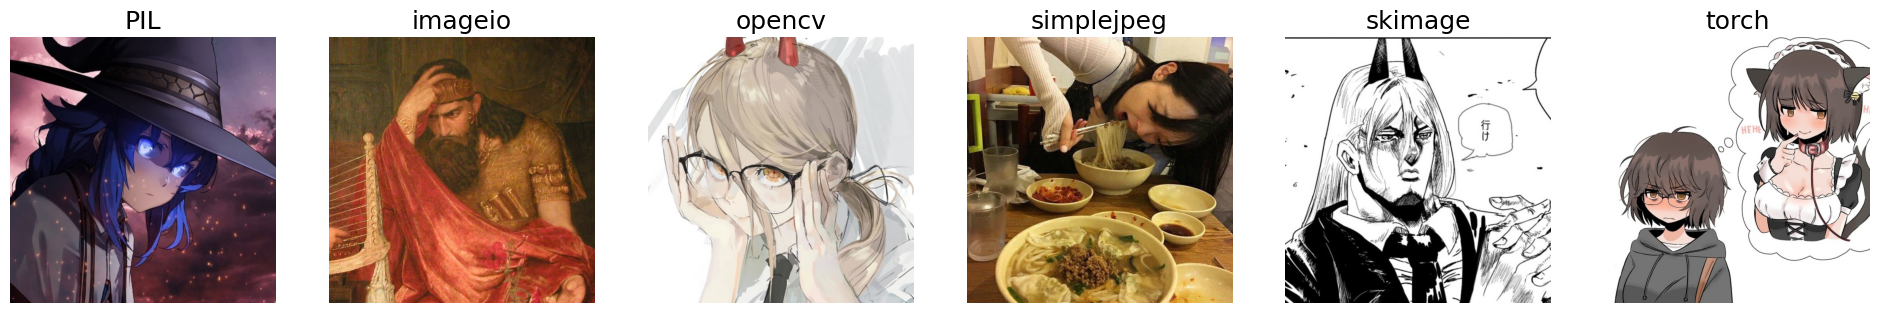

In [37]:
import inspect

import cv2
import imageio
import simplejpeg
import matplotlib.pyplot as plt
import numpy as np
import skimage
from PIL import Image

from torchvision.io import read_image


class GetArray:
    def PIL(self, image_path: str) -> np.array:
        img = Image.open(image_path)
        img = img.convert("RGB")
        return np.asarray(img)

    def opencv(self, image_path: str) -> np.array:
        img = cv2.imread(image_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def simplejpeg(self, image_path: str) -> np.array:
        with open(image_path, 'rb') as f:
            return simplejpeg.decode_jpeg(f.read(), colorspace='RGB')

    def skimage(self, image_path: str) -> np.array:
        return skimage.io.imread(image_path)

    def imageio(self, image_path: str) -> np.array:
        return imageio.v2.imread(image_path)

    def torch(self, image_path: str) -> np.array:
        return read_image(image_path).numpy().transpose(1,2,0)


array_getter = GetArray()
methods_pool = inspect.getmembers(array_getter, predicate=inspect.ismethod)
print("Methods pool: ", [method_name for method_name, method in methods_pool], "\n")

fig, axs = plt.subplots(1, 6, figsize=(24, 6))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(methods_pool[i][1](f"pics/1/{i + 1}.jpg"))
    ax.set_title(methods_pool[i][0], fontsize=18)

Now, let's examine the code of `image_loaders_benchmark.py`, which runs image decoding with the frameworks above 2000 times and check the time consumption of each algorithm.

Run `python3 image_loaders_benchmark.py -d pics/1`.

In [38]:
!python3 image_loaders_benchmark.py -d pics/1

Current benchmark: opencv | GetArray: 100%|███████| 1/1 [00:00<00:00,  7.81it/s]
Current benchmark: PIL | GetArray: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]
Current benchmark: simplejpeg | GetArray: 100%|███| 1/1 [00:00<00:00, 18.41it/s]
Current benchmark: skimage | GetArray: 100%|██████| 1/1 [00:00<00:00,  3.77it/s]
Current benchmark: imageio | GetArray: 100%|██████| 1/1 [00:00<00:00,  8.68it/s]
Current benchmark: torch | GetArray: 100%|████████| 1/1 [00:00<00:00, 15.54it/s]
         opencv  PIL simplejpeg skimage imageio torch
GetArray    313  473        738     284     348   623


## 5. Data augmentations on GPU: Nvidia DALI

Nvidia DALI allows moving CPU workloads to GPU in some cases, including (but not limited to) data loading and data preprocessing.
This might be useful if you have a CPU bottleneck in your setup.

Check out the documentation [page](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html) and [guidelines](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/use_cases/pytorch/resnet50/pytorch-resnet50.html) for convolutional network training on ImageNet with DALI.
The source code from this example is [here](https://github.com/NVIDIA/DALI/blob/c572c3f98a1cfccdcca37ba4e4538419913e54fd/docs/examples/use_cases/pytorch/resnet50/main.py).

For this seminar, let's borrow the augmentations demo from docs of DALI.

In [ ]:
# !git clone https://github.com/NVIDIA/DALI_extra.git

In [39]:
import math
import os.path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def

test_data_root = "DALI_extra"
db_folder = os.path.join(test_data_root, "db", "lmdb")

In [40]:
augmentations = dict()

# input is sampled randomly for output pixel's neighbourhood
augmentations["erase"] = lambda images: fn.erase(
    images,
    anchor=[0.3, 0.2],
    shape=[0.5, 0.6],
    normalized_anchor=True,
    normalized_shape=True,
    axis_names="HW",
)
augmentations["slice"] = lambda images: fn.slice(
    images, rel_start=[0.3, 0.2], rel_shape=[0.5, 0.6], axis_names="HW"
)
# transforms sampling coordinates to produce wavy patterns
augmentations["water"] = lambda images: fn.water(images)
# applies fisheye distortion
augmentations["sphere"] = lambda images: fn.sphere(images)
# rotates the image, enlarging the canvas
augmentations["rotate"] = lambda images: fn.rotate(
    images, angle=30, interp_type=types.INTERP_LINEAR, fill_value=0
)
# applies affine transform
augmentations["warp_affine"] = lambda images: fn.warp_affine(
    images, matrix=[1.0, 0.8, 0.0, 0.0, 1.2, 0.0], interp_type=types.INTERP_LINEAR
)
# manipulates brightness and contrast of the image
augmentations["brightness_contrast"] = lambda images: fn.brightness_contrast(
    images, brightness=0.5, contrast=1.5
)
# Generate JPEG compression artifacts
augmentations[
    "jpeg compression distortion"
] = lambda images: fn.jpeg_compression_distortion(images, quality=5)
# twists colors of the image
augmentations["hsv"] = lambda images: fn.hsv(images, hue=45.0, saturation=0.2)
# places the image on a larger canvas
augmentations["paste"] = lambda images: fn.paste(
    images, ratio=2.0, fill_value=(55, 155, 155), paste_x=0.1, paste_y=0.7
)
# param flips the image
augmentations["vertical and horizontal flip"] = lambda images: fn.flip(
    images, vertical=1, horizontal=1
)

In [41]:
@pipeline_def()
def augmentation_gallery_pipe(path):
    encoded, labels = fn.readers.caffe(path=path, random_shuffle=True)
    images = fn.decoders.image(encoded, device="mixed", output_type=types.RGB)
    return tuple([labels, images] + [aug(images) for aug in augmentations.values()])


pipe = augmentation_gallery_pipe(
    path=db_folder, batch_size=32, num_threads=2, device_id=0, seed=10
)
pipe.build()

Examine your GPU load with `nvidia-smi` while running the next cell.

In [42]:
for i in range(500):
    pipe_out = pipe.run()

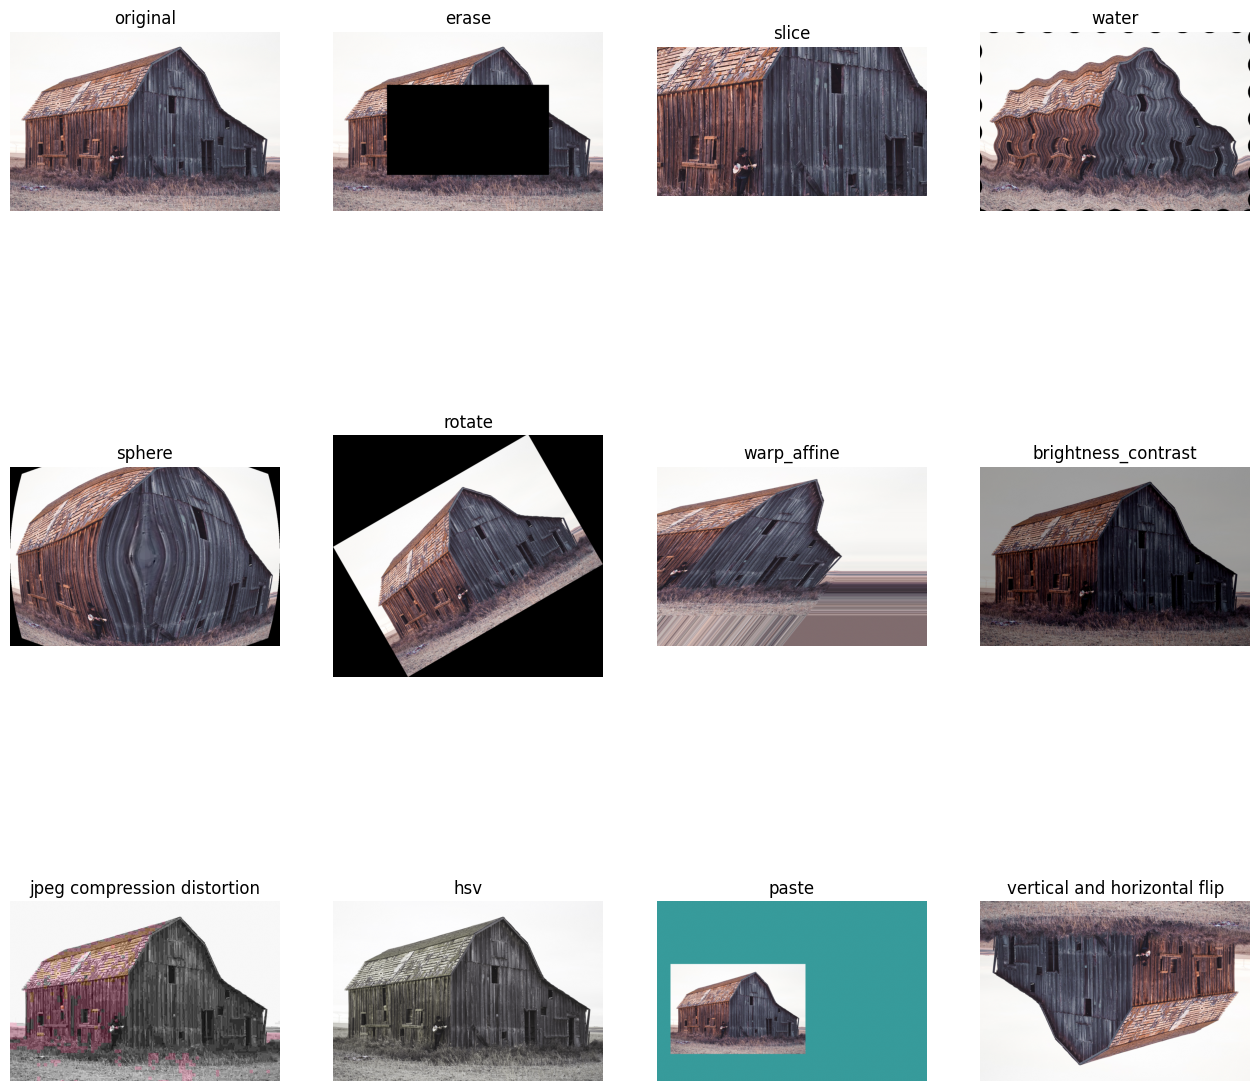

In [43]:
n = 5
len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(augmentations.keys())
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow(img_chw / 255.0)